# ML based computer vision indoor climbing analysis
 
In this ML analysis, we implement a sequential detection strategy:
- First, hold detection is performed using a YOLOv8 Detection model to retrieve the climbing holds.
- Then, color detection is applied using a fine-tuned Vision Transformer (ViT) multi-label classification model to classify the holds by their color, helping to identify different routes.
 
These models have been fine-tuned on both color and hold datasets of indoor climbing holds to achieve superior performance compared to traditional computer vision techniques.



image 1/1 /Users/gabrielemasciulli/Desktop/uni/master/1°st year/1°st semester/Image Signal Processsing/Project/immagini test/IMG_006.jpg: 480x640 142 0s, 38.1ms
Speed: 1.5ms preprocess, 38.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


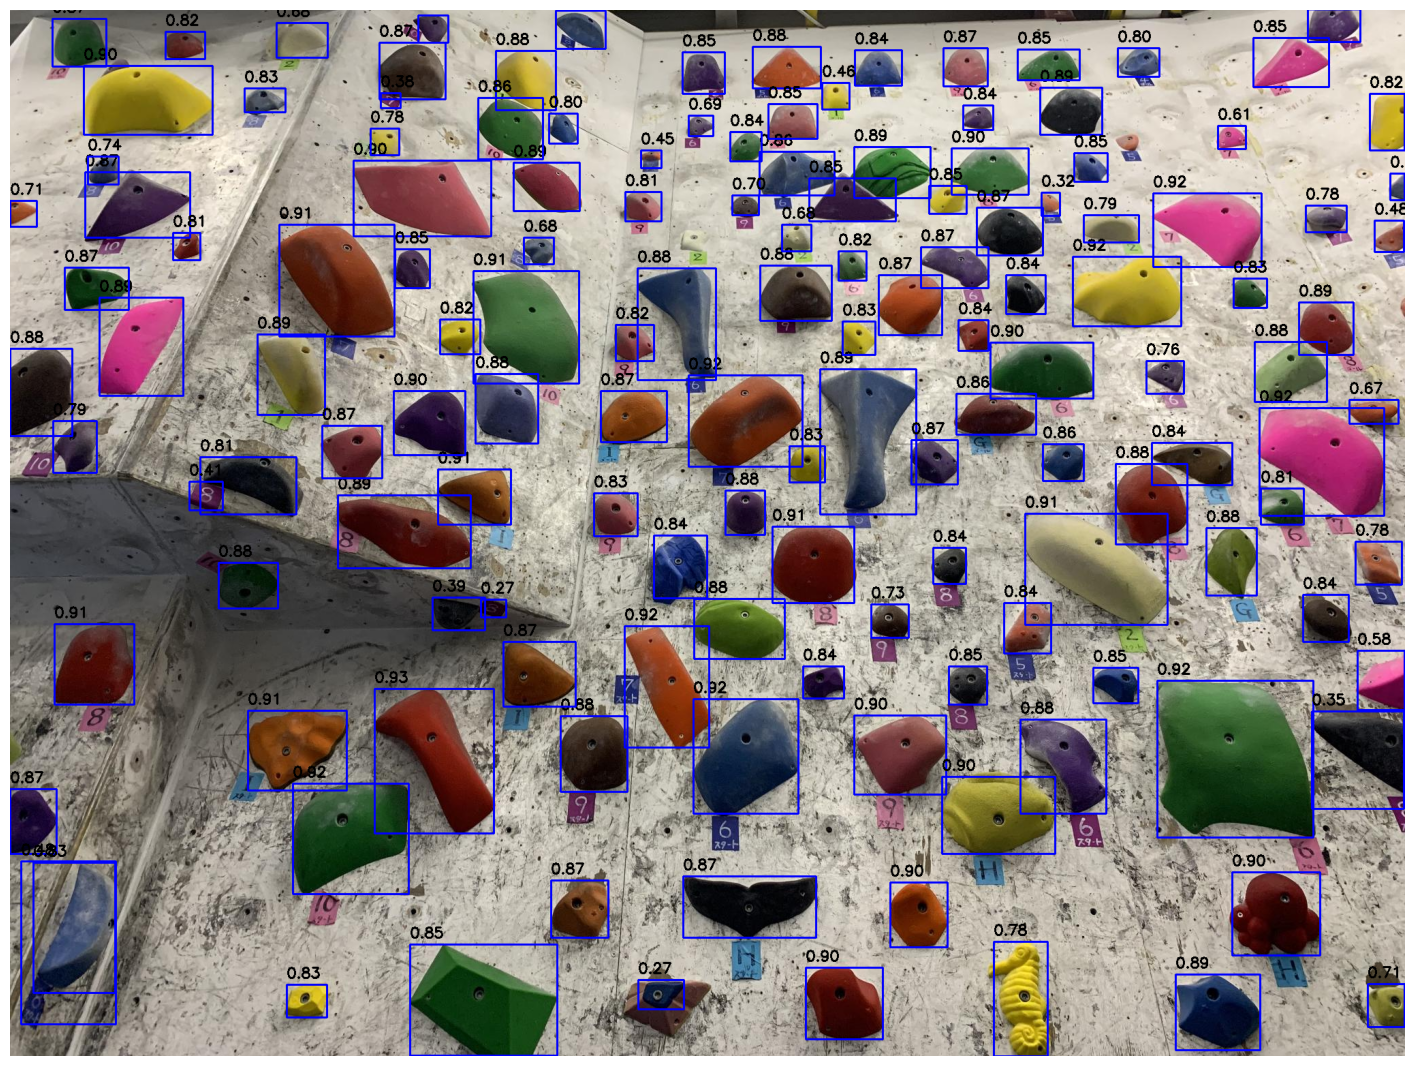

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO("./weights/hold_weights.pt")  

image_path = "./immagini test/IMG_006.jpg"  
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run inference
results = model(image_path)

# Color used for the bounding boxes
color = (0, 0, 255)  

# Array which will contain all the coordinates of the holds detected by the model
hold_coordinates = []

# Process results
for result in results:
    for box in result.boxes:
        # Convert tensor values to readable format
        class_id = int(box.cls.item())  
        confidence = float(box.conf.item())  
        x1, y1, x2, y2 = map(int, box.xyxy.cpu().numpy().flatten())  

        hold_coordinates.append([x1, y1, x2, y2])

        # Draw bounding box onto the original image
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), color, 2)

        # Label with confidence (if recognized as a hold)
        label = f"{confidence:.2f}"
        cv2.putText(image_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

# convert the list to a numpy array (used for multi-label classification later in the notebook)
hold_coordinates = np.array(hold_coordinates)

# Save the image with bounding boxes
output_path = "./output/detected_holds.jpg"
image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)
cv2.imwrite(output_path, image_bgr)

# Plot image using Matplotlib
plt.figure(figsize=(18, 18))
plt.imshow(image_rgb)
plt.axis("off")  
plt.show()


Processing holds: 100%|██████████| 142/142 [01:55<00:00,  1.23it/s]


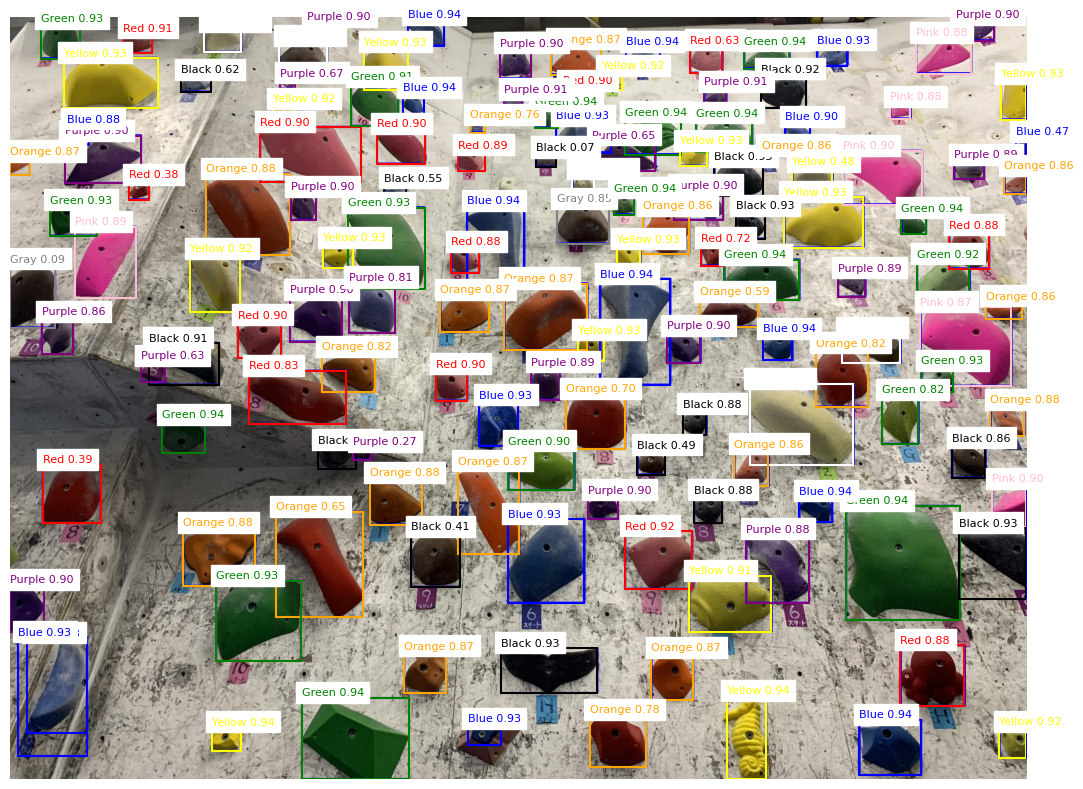

In [28]:
from inference_sdk import InferenceHTTPClient
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

# Initialize the roboflow client
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="n8S64aezSPRiiIDZ0fAb"
)

# Create a directory to save the sub-images (holds found by the model)
output_dir = "./output/detected-holds-images"
os.makedirs(output_dir, exist_ok=True)

# Lists to store the raw inference results and hold info for visualization
predictions_list = []
holds_info = [] # each element will contain the coordinates and predicted color

# Process each hold found
for idx, (x1, y1, x2, y2) in enumerate(tqdm(hold_coordinates, desc="Processing holds")):
    # Crop the sub-image for this hold
    sub_img = image_rgb[y1:y2, x1:x2]
    
    sub_img_bgr = cv2.cvtColor(sub_img, cv2.COLOR_RGB2BGR)
    
    # Save the sub-image to a file
    output_path = os.path.join(output_dir, f"hold_{idx}.jpg")
    cv2.imwrite(output_path, sub_img_bgr)
    
    # Call the inference API on the sub-image
    sub_result = CLIENT.infer(output_path, model_id="hold-color-detector/1")
    predictions_list.append(sub_result)
    
    # Extract predictions and filter out unknown or unlabeled entries
    predictions = sub_result.get("predictions", {})
    if predictions:
        valid_predictions = {
            color: details for color, details in predictions.items()
            if color.strip() and color.lower() not in ["unknown", "unlabeled"]
        }
        if not valid_predictions:
            continue
        
        # Pick the color with the highest confidence from valid predictions
        best_color = max(valid_predictions, key=lambda color: valid_predictions[color].get("confidence", 0))
        confidence = valid_predictions[best_color].get("confidence", 0)
    else:
        continue

    # Save hold info for later
    holds_info.append({
        "x1": x1,
        "y1": y1,
        "x2": x2,
        "y2": y2,
        "color": best_color,
        "confidence": confidence
    })

# Create a visualization: draw each hold as a rectangle on the original image
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image_rgb)

# Add a rectangle for each hold
for hold in holds_info:
    x1, y1, x2, y2 = hold["x1"], hold["y1"], hold["x2"], hold["y2"]
    width, height = x2 - x1, y2 - y1
    color = hold["color"]
    confidence = hold["confidence"]

    rect = patches.Rectangle((x1, y1), width, height, linewidth=1.5,
                             edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    
    # Annotate the rectangle with the predicted color and its confidence
    ax.text(x1, max(y1 - 5, 0), f"{color} {confidence:.2f}",
            color=color, fontsize=8, backgroundcolor='w')

ax.axis('off')
plt.tight_layout()

plt.show()

# Save the annotated image locally
fig.savefig("./output/annotated_holds.png", dpi=300)


In [29]:
import json

# Convert hold_coordinates to a list if it's a numpy array to ensure JSON serializability
hold_coordinates_serializable = hold_coordinates.tolist() if hasattr(hold_coordinates, "tolist") else hold_coordinates
if isinstance(hold_coordinates_serializable, list):
    hold_coordinates_serializable = [[int(coord) for coord in inner_list] if isinstance(inner_list, list) else int(inner_list) for inner_list in hold_coordinates_serializable]


holds_info_serializable = []

for hold_info in holds_info:
    holds_info_serializable.append({
        "x1": int(hold_info["x1"]),
        "y1": int(hold_info["y1"]),
        "x2": int(hold_info["x2"]),
        "y2": int(hold_info["y2"]),
        "color": hold_info["color"],
        "confidence": float(hold_info["confidence"])
    })

data = {
    "hold_coordinates": hold_coordinates_serializable,
    "holds_info": holds_info_serializable
}

try:
    with open("./output/hold_info.json", "w") as f:
        json.dump(data, f)
except Exception as e:
    print(f"Error writing to JSON file: {e}")
